# S500 Project Stations Mapping: Weather and Economic Growth

Mapping the availability of weather stations over time in the NOAA dataset, associated with the s500-project on ac-99's github. Makes use of routines from [GeoPandas](https://geopandas.org/en/stable/docs/user_guide/mapping.html).

Author: Anubhav Chowdhury, University of Cambridge (MPhil in Economic Research), https://github.com/ac-99

Date: May 2022

Project abstract: This essay exploits year-to-year temperature and precipitation variation to estimate the effects of weather on economic growth using fixed effects methods, a la Dell (2012). This essay hypothesises, based on a large volume of micro-level evidence, that agricultural effects mediate the relationship between weather and economic growth. This problem is analysed using fixed effects regression methods, using dynamic measures for poverty and agriculture, rather than the static measures used by Dell (2021). This analysis is based on a US National Oceanic and Atmospheric Administration (NOAA) dataset with over 90 million observations from over 15,000 weather stations and World Bank Development Indicators between 1992 and 2017. 

In [1]:
# Analysis Packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bq_helper # BigQuery

# Plotting packages
from shapely.geometry import Point 
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 300 # For high quality outputs
sns.set_palette("magma")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import shutil
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


/kaggle/input/noaa-csv/noaa.csv
/kaggle/input/noaastationslatlon/stations.csv


In [2]:
# Import data
stations = pd.read_csv('../input/noaastationslatlon/stations.csv') # Created as part of ``S500 Analysis'' Project (see repo). All NOAA stations.
stations_small = stations.copy().groupby('usaf').mean() # Groupby to get relevant averages/reduce dataset size
stations_small['year']=stations_small['year'].astype('int') # Fix types

### Generate Plots

#### Generate a USAF stations map for each year

1985, 1995, 2005 and 2015 are chosen to explore data availability (particularly, station consistency) over the period of years of interest.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_size" which is no longer supported as of 3.3 and will become an error in 3.6
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_size" which is no longer supported as of 3.3 and will become an error in 3.6
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_size" which is no longer supported as of 3.3 and will become an error in 3.6
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_size" which is no longer supported as of 3.3 and will become an error in 3.6


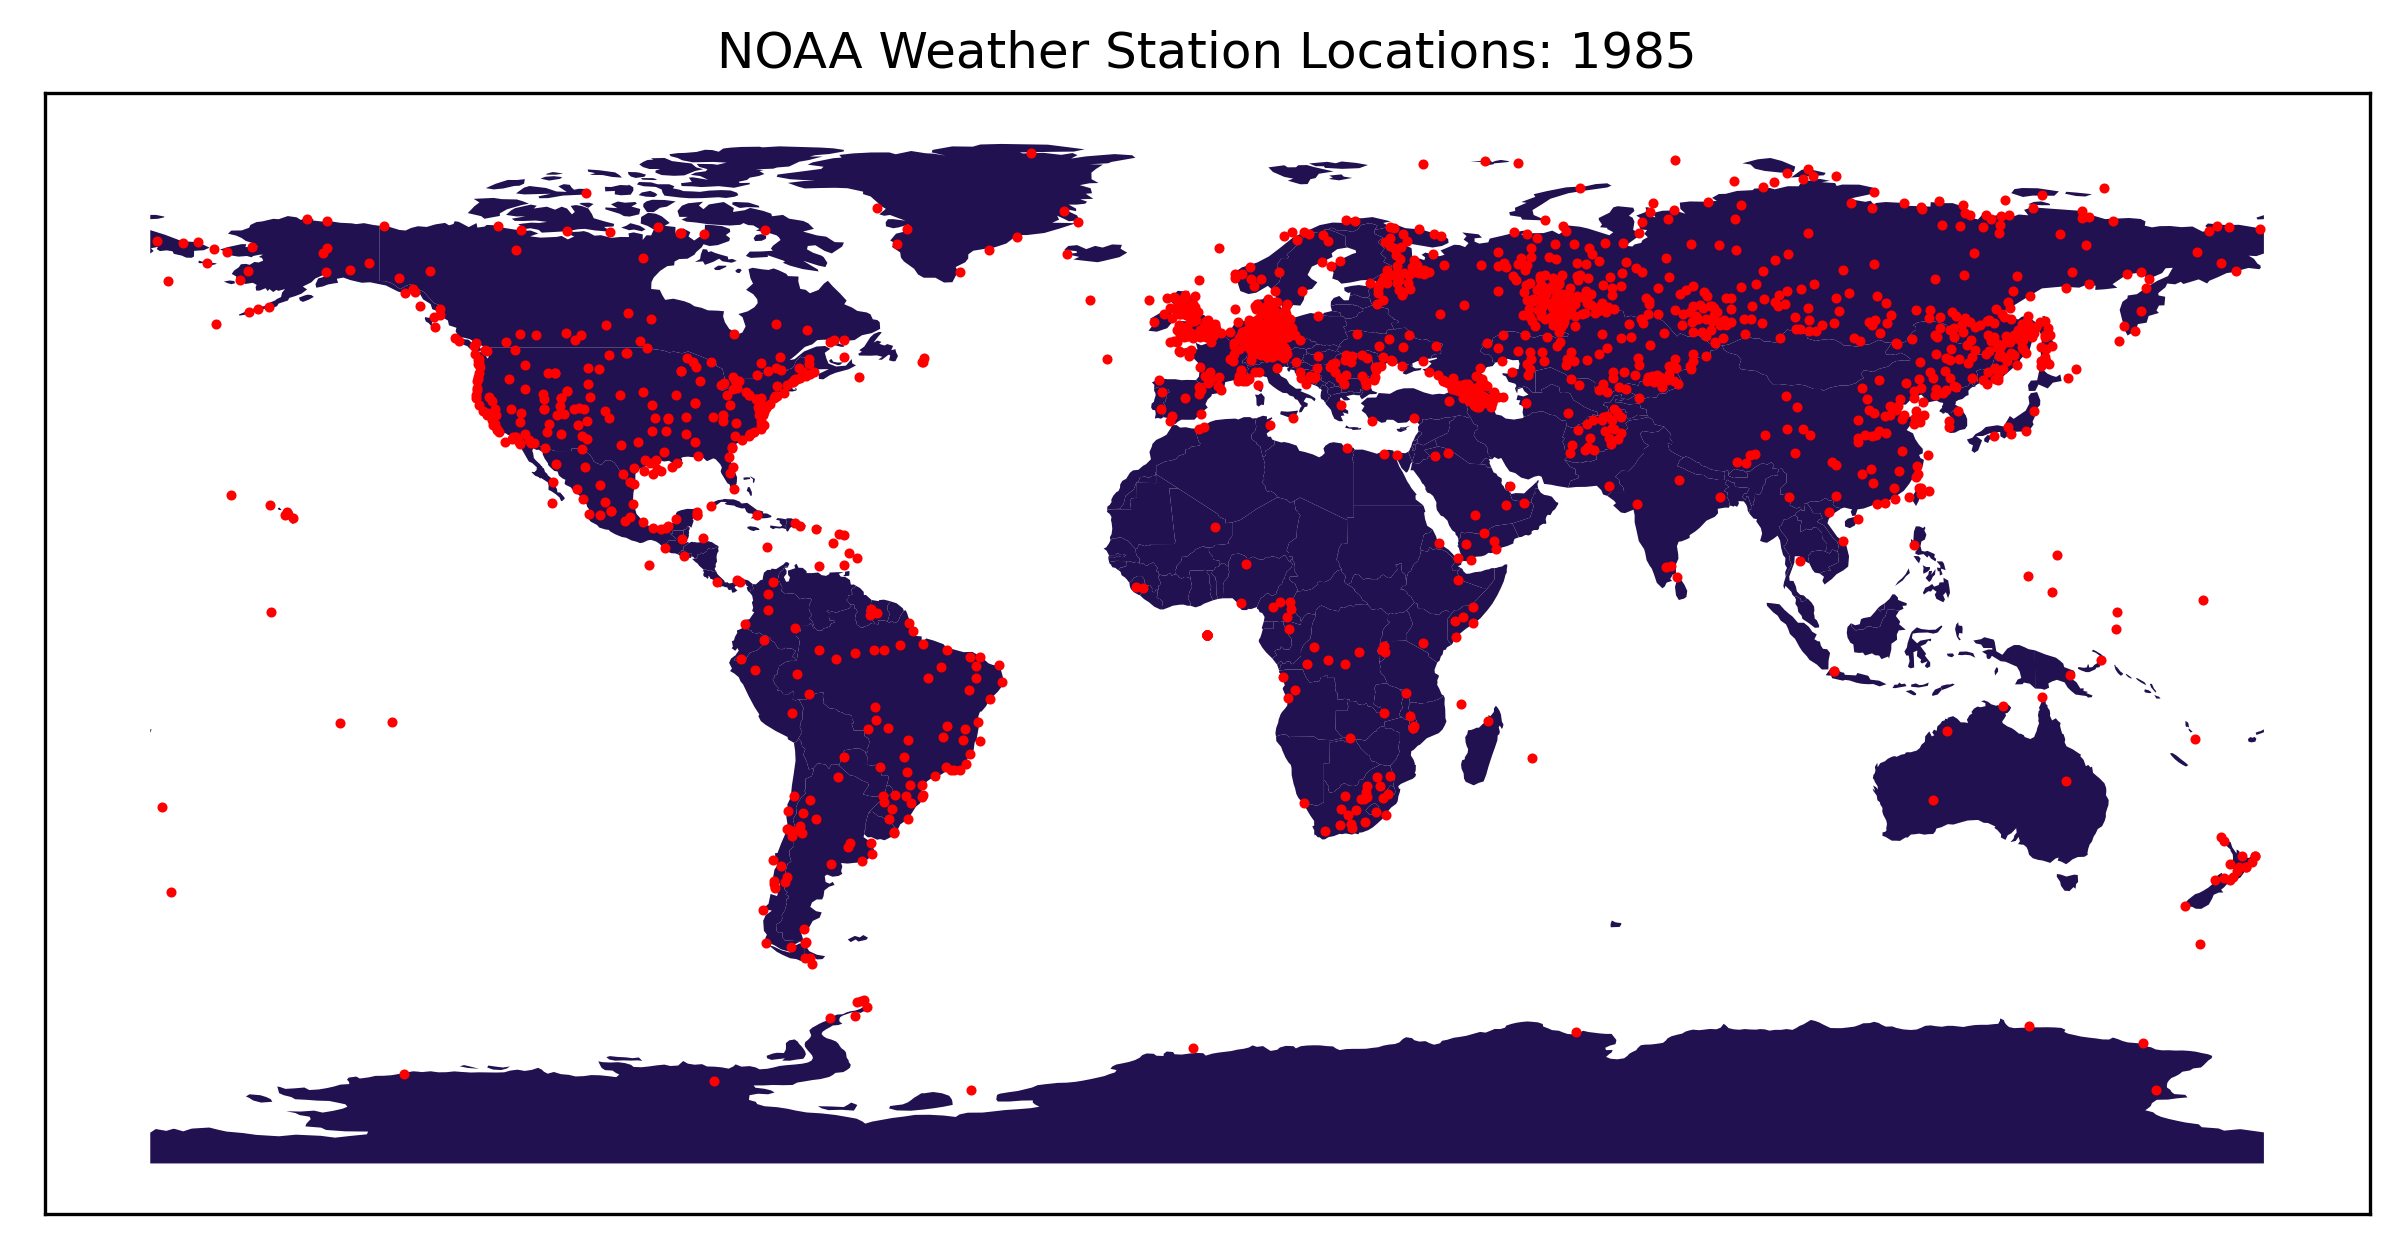

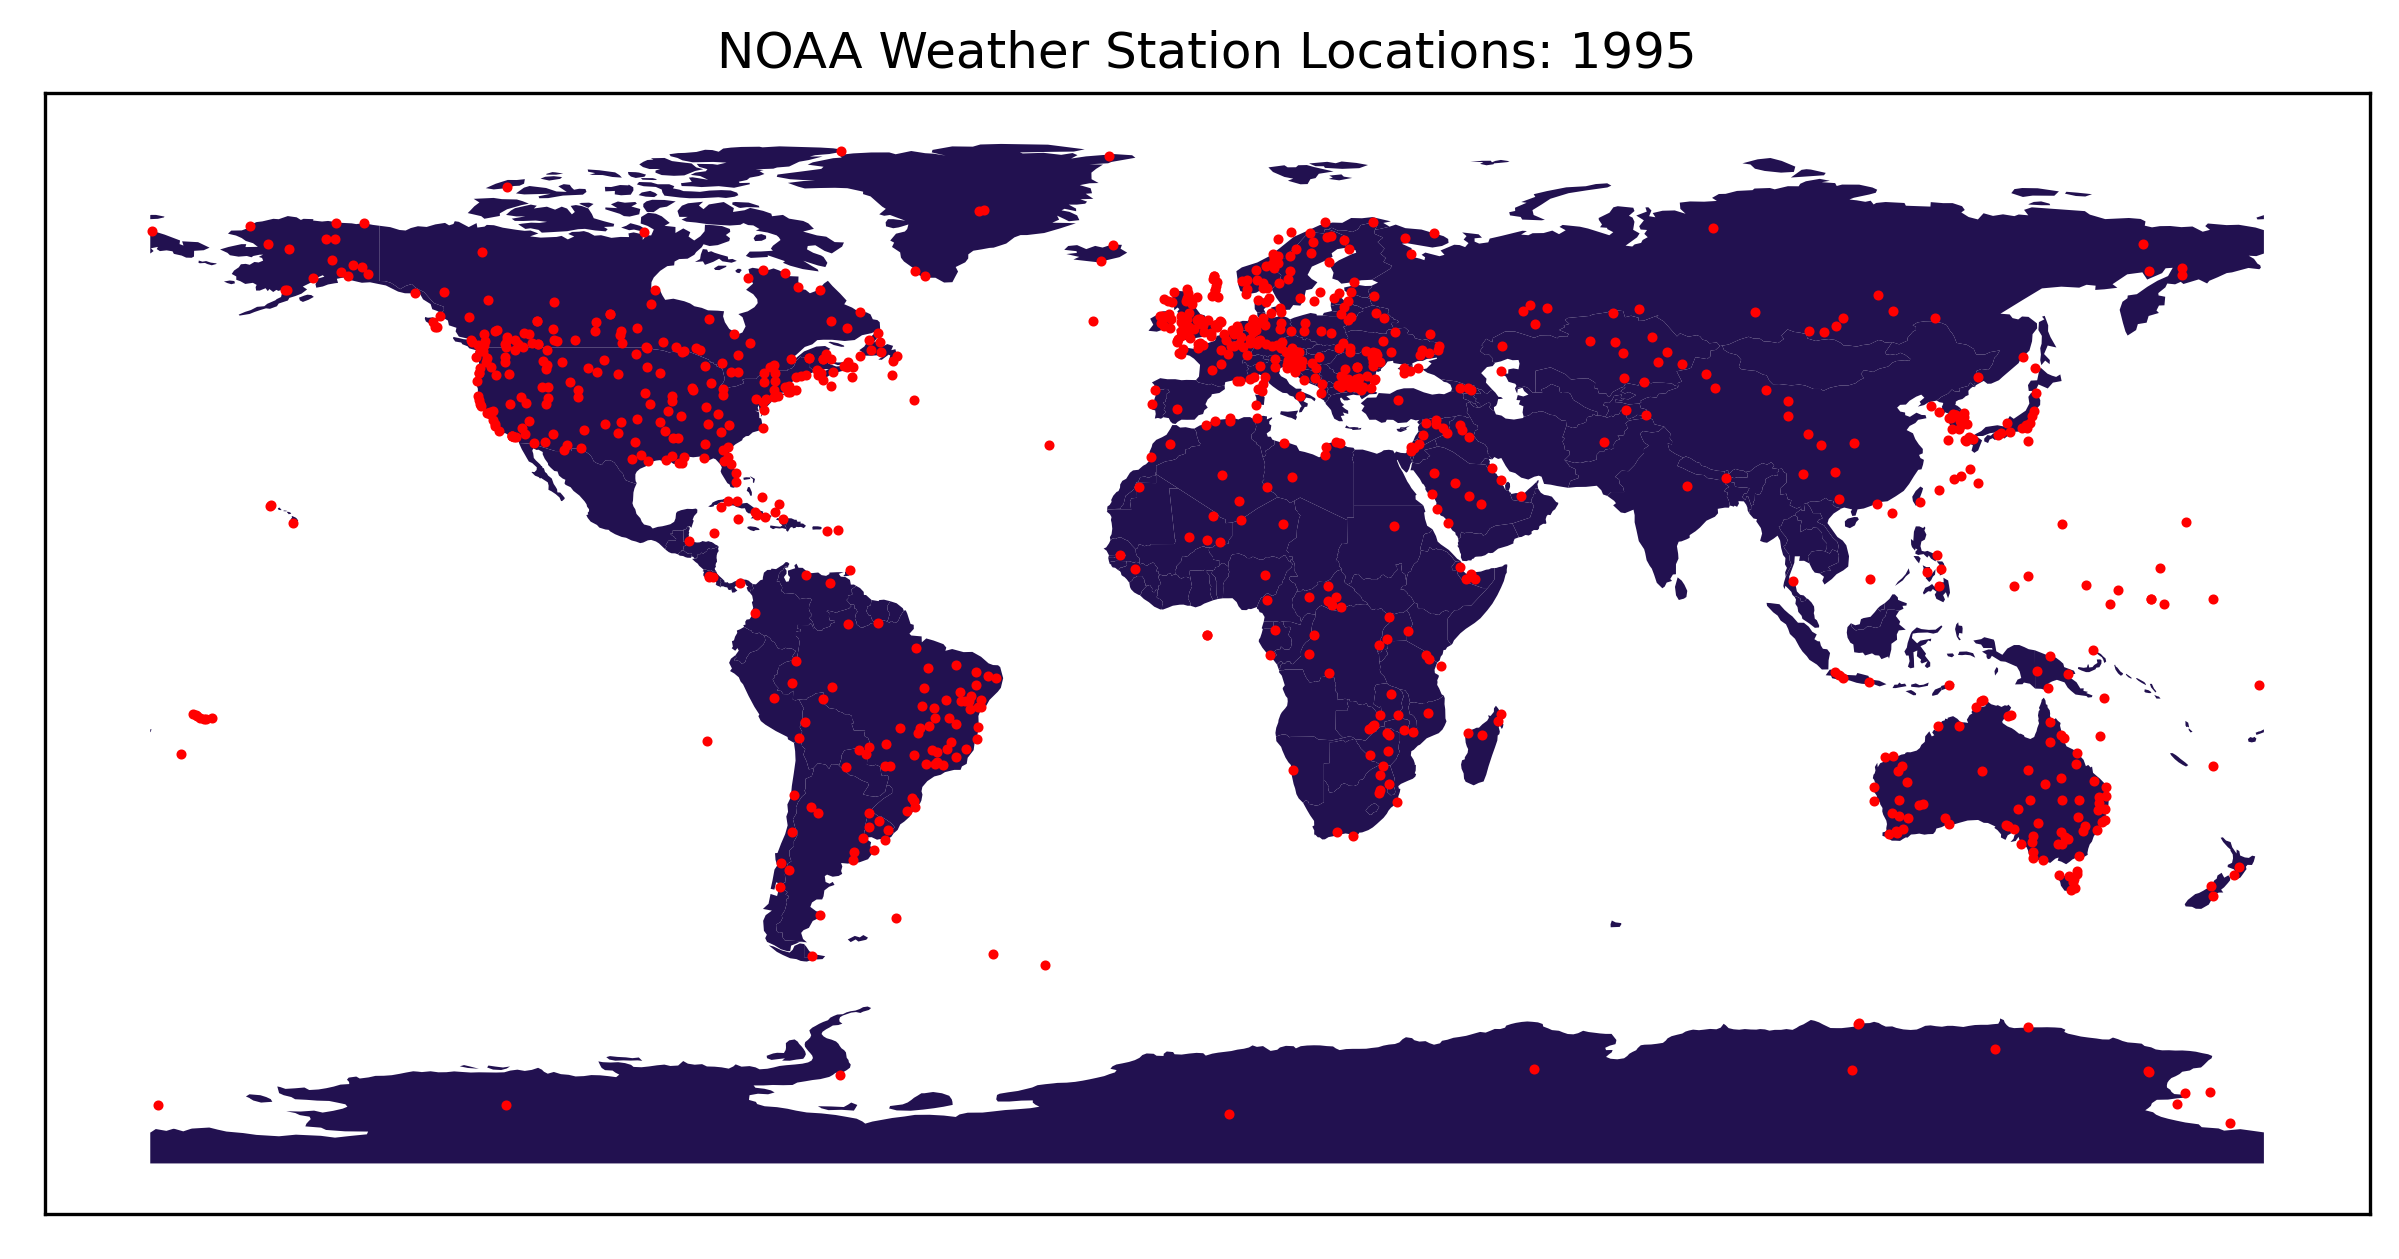

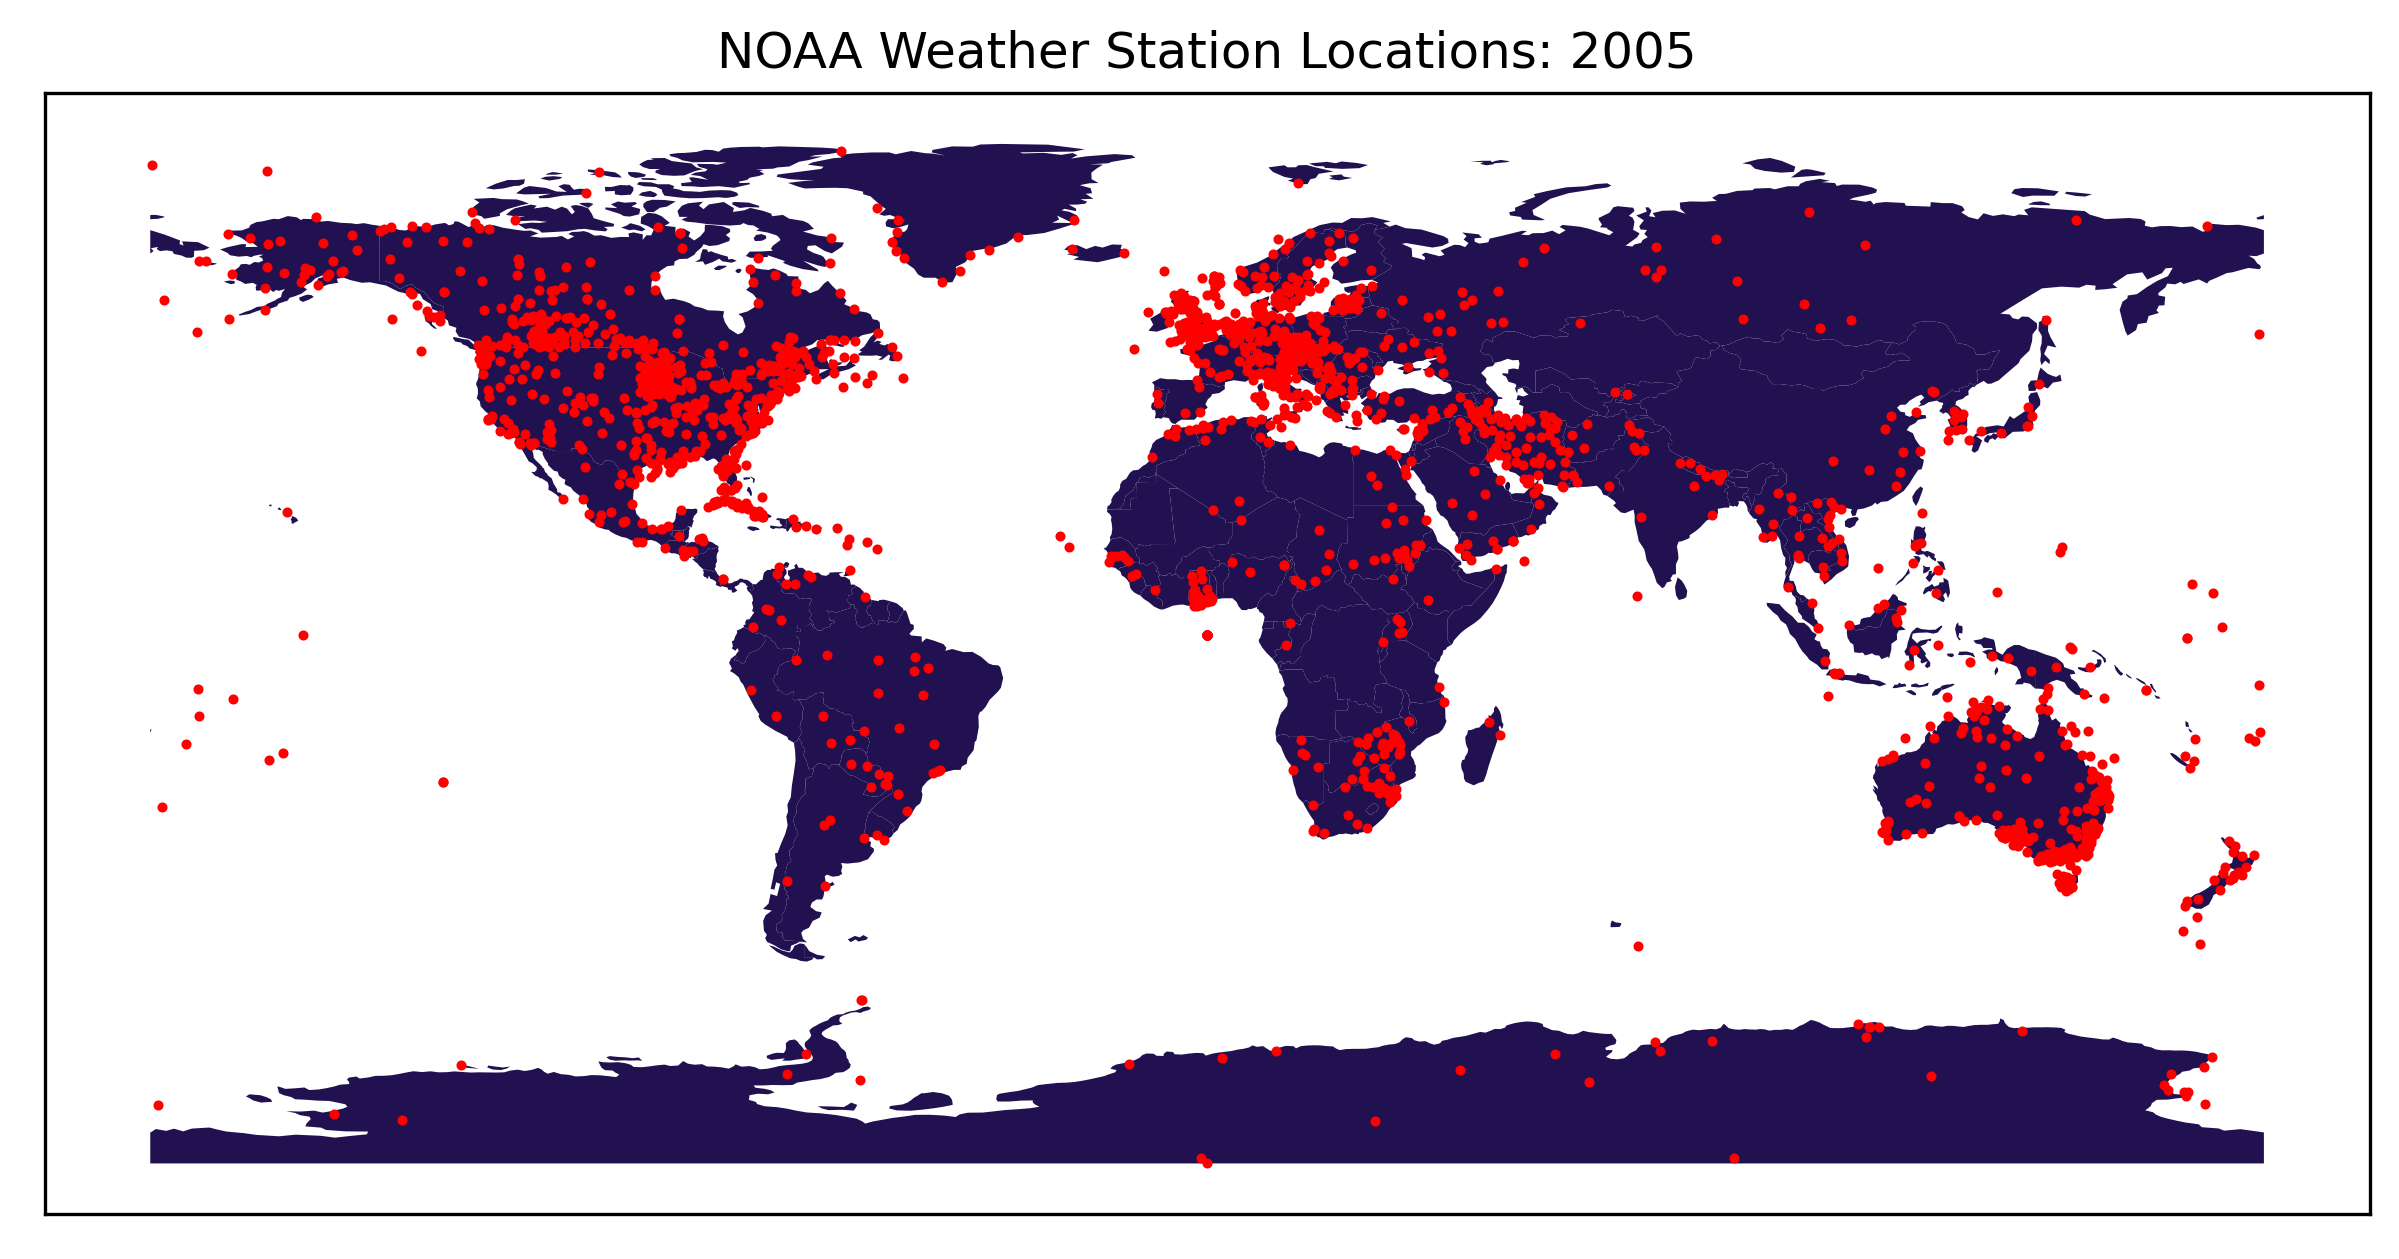

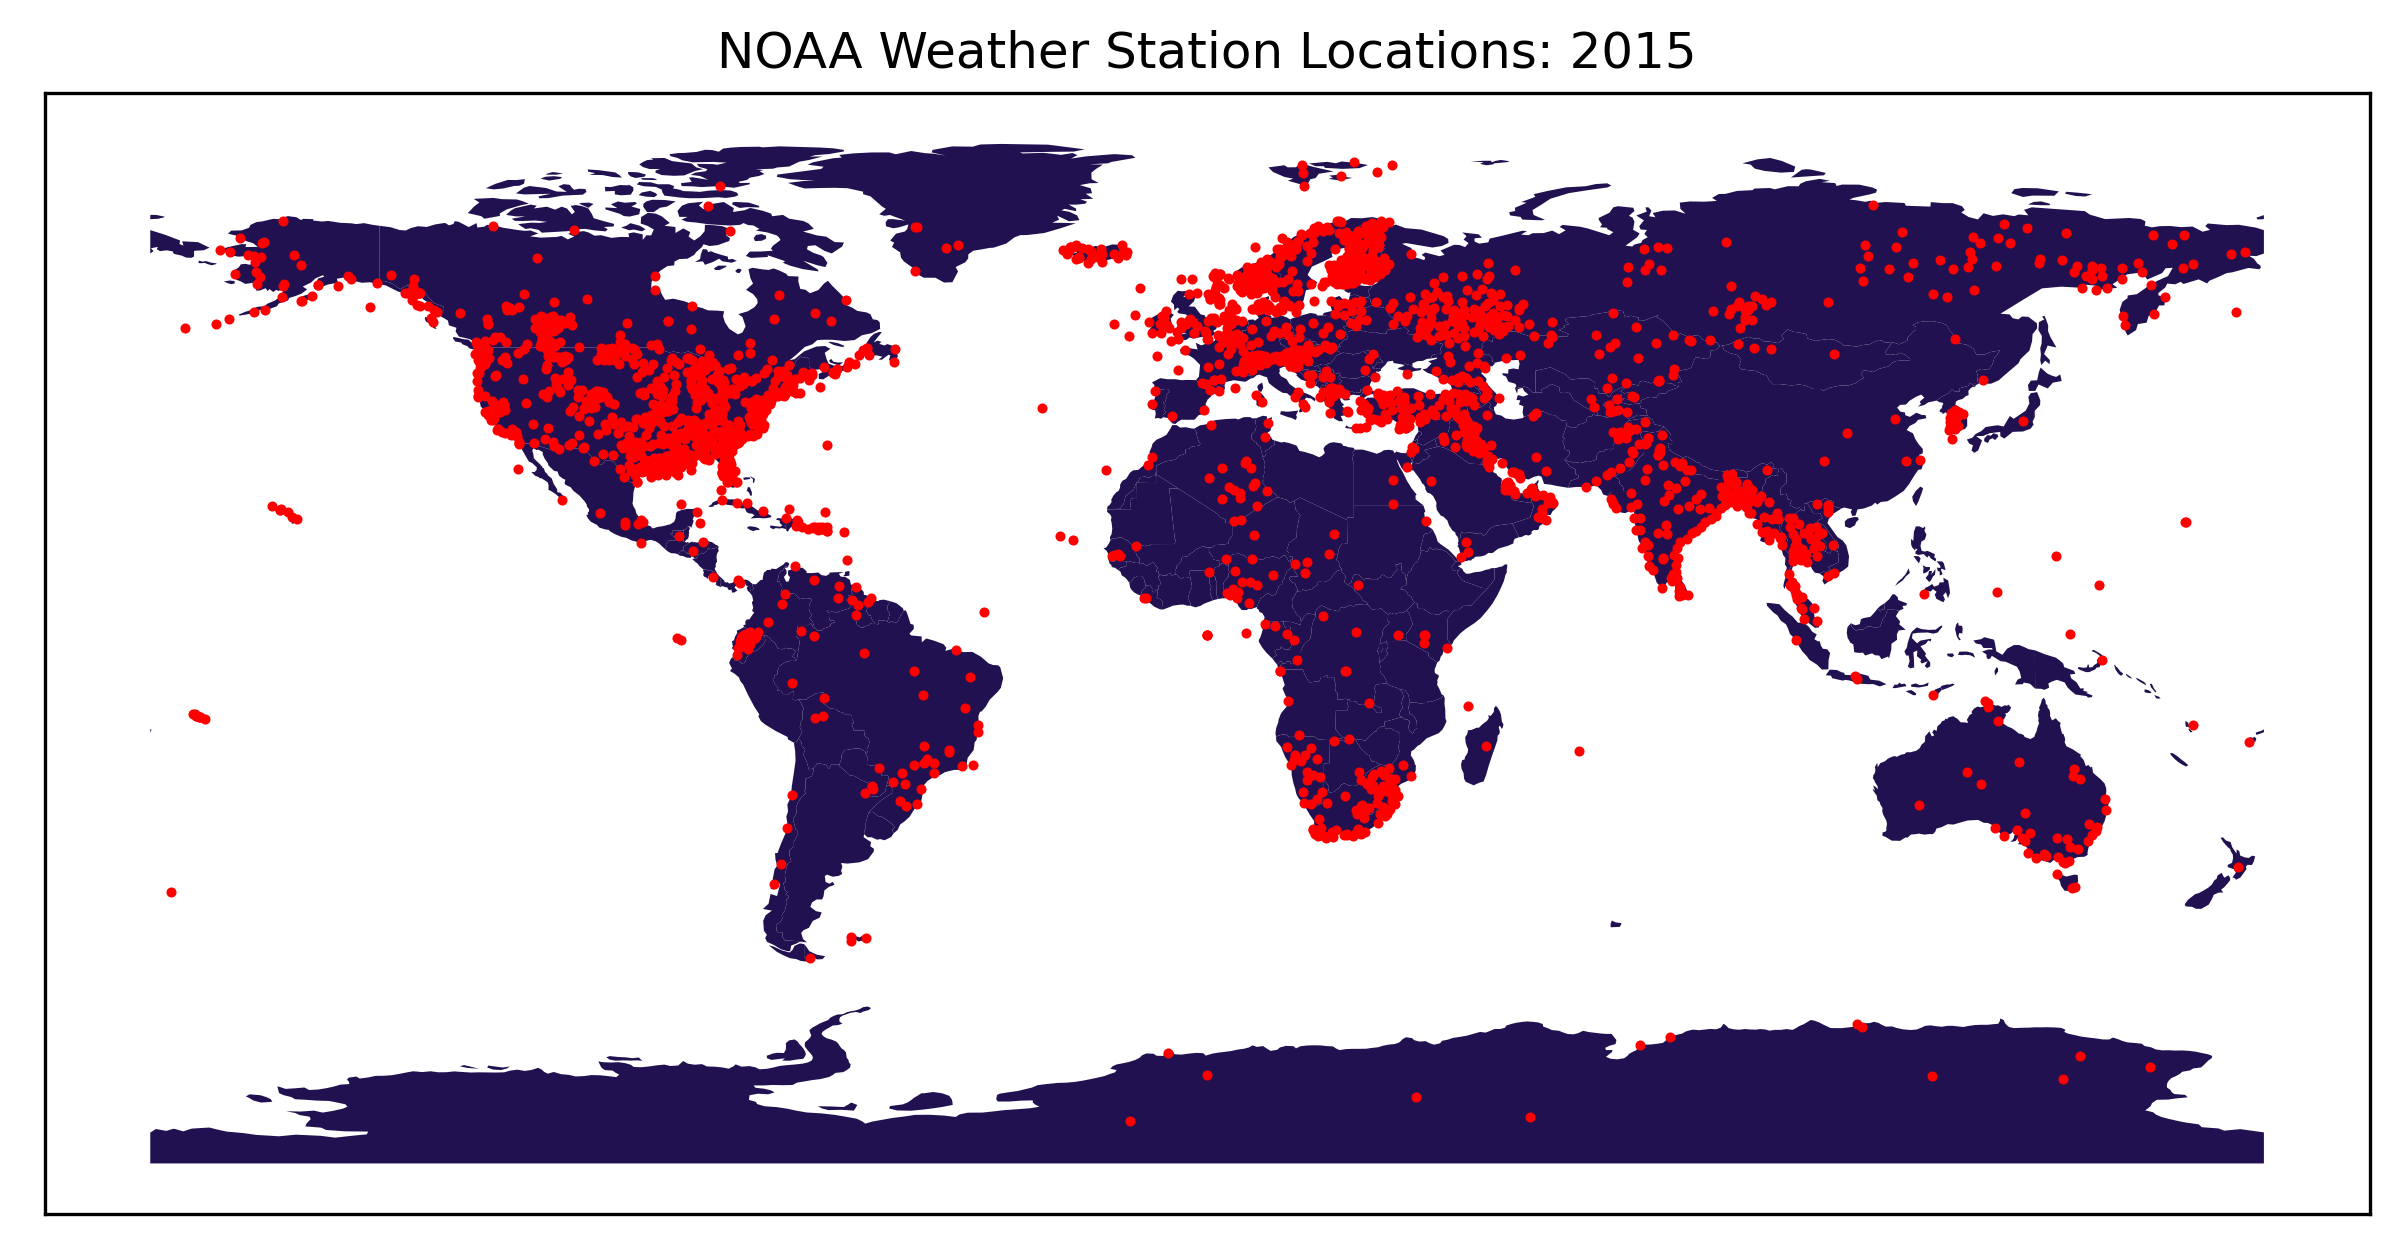

In [3]:
years=[1985,1995,2005,2015]
for year in years:
    
    # Create object which maps lat-long points of the stations
    geometry = [Point(xy) for xy in zip(stations_small['lon'][stations_small['year']==year], 
                                        stations_small['lat'][stations_small['year']==year])]
    
    # Use above object to create Geopandas DF
    gdf = GeoDataFrame(stations_small[stations_small['year']==year], geometry=geometry)
    
    # Generate map based on Geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Standard plotting using matplotlib
    ax=world.plot(figsize=(10,8)) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(label="NOAA Weather Station Locations: {}".format(year)) # Option of naming plots based on year 
    plot = gdf.plot(ax=ax, 
                    marker='o',
                    color='red',
                    markersize=2)
    
    plt.savefig(fname=str(year),bbox_size='tight',pad_inches=0) 
    plt.plot()

#### Generate plot with GDP overlay 

Visual (non-statistical) evidence of poorer station coverage in poorer nations. Attention restricted to 2015.

/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_size" which is no longer supported as of 3.3 and will become an error in 3.6


[]

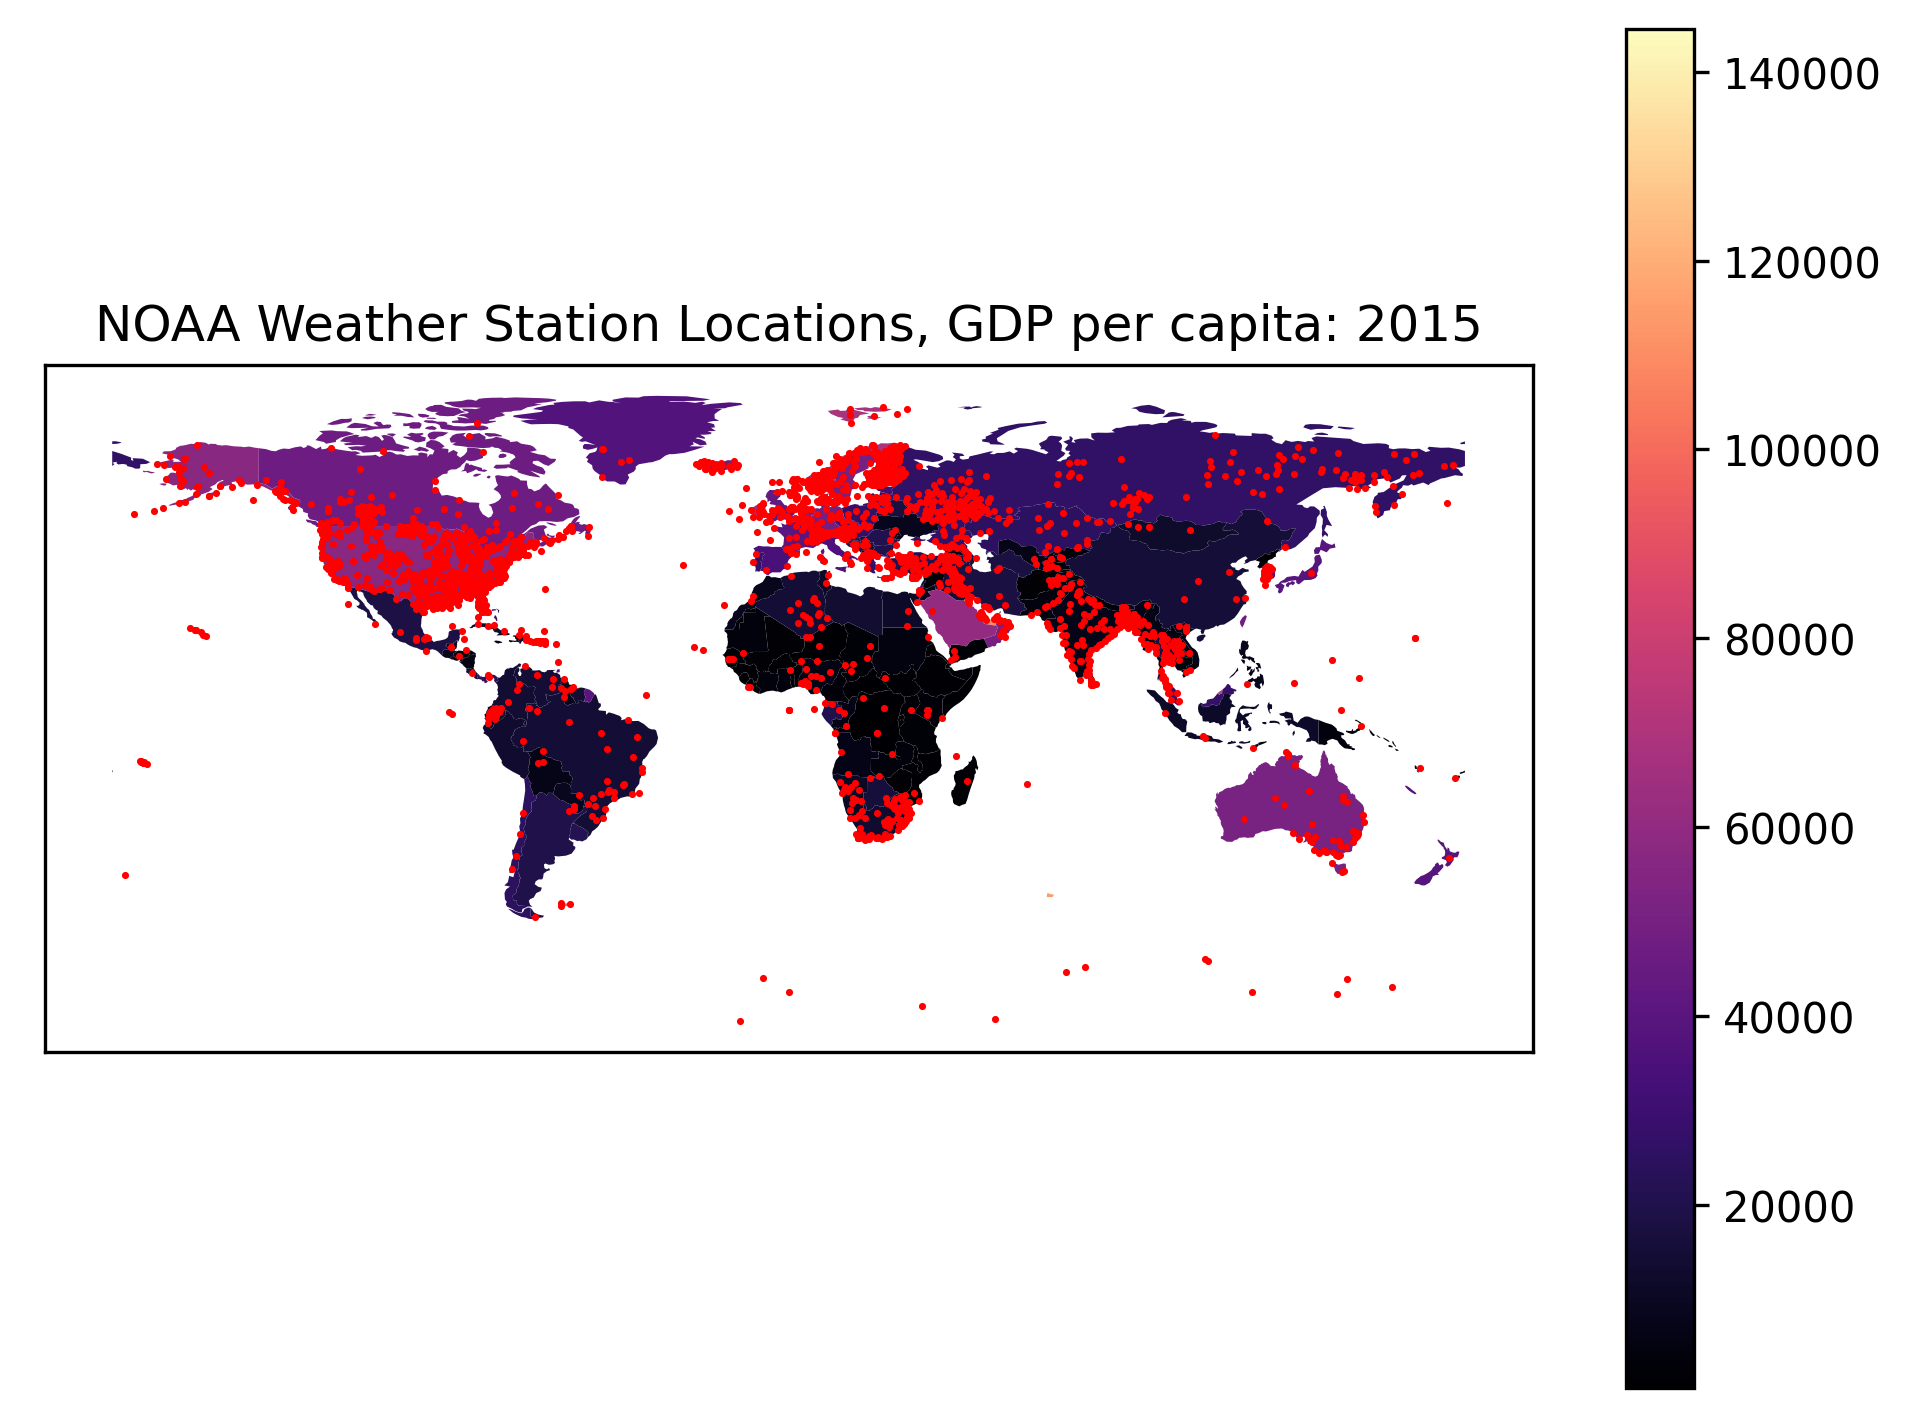

In [4]:
year=2015 # Focus on just 2015

world = world[(world.pop_est>0) & (world.name!="Antarctica")] # Drop countries without positive populations
world['gdp_per_cap'] = world.gdp_md_est*1000000 / world.pop_est # Use existing data on population estimates

# Lat-long coordinates in map-format
geometry = [Point(xy) for xy in zip(stations_small['lon'][stations_small['year']==year], 
                                        stations_small['lat'][stations_small['year']==year])]

# Geopandas df
gdf = GeoDataFrame(stations_small[stations_small['year']==year], geometry=geometry)   
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # already read in above

# Plotting
ax=world.plot(figsize=(8,6),column='gdp_per_cap',cmap="magma",legend=True) # use CMAP and include gdp_per_cap
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(label="NOAA Weather Station Locations, GDP per capita: {}".format(year)) # Named plot
plot = gdf.plot(ax=ax, 
                  marker='o',
                color="red",
                 markersize=0.5)
#     plots.append(plot) 
# Output
plt.savefig(fname="stations-gdp-per-capita",bbox_size='tight',pad_inches=0) 
plt.plot()